<div style="
    background: rgba(25, 25, 25, 0.55);
    backdrop-filter: blur(16px) saturate(150%);
    -webkit-backdrop-filter: blur(16px) saturate(150%);
    border: 1px solid rgba(255, 255, 255, 0.12);
    border-radius: 18px;
    padding: 45px 30px;
    text-align: center;
    font-family: 'Inter', 'Segoe UI', 'Helvetica Neue', Arial, sans-serif;
    color: #e0e0e0;
    box-shadow: 0 0 30px rgba(0, 0, 0, 0.35);
    margin: 40px auto;
    max-width: 800px;
">

  <h1 style="
      font-size: 2.8em;
      font-weight: 700;
      margin: 0 0 8px 0;
      letter-spacing: -0.02em;
      background: linear-gradient(90deg, #00e0ff, #9c7eff);
      -webkit-background-clip: text;
      -webkit-text-fill-color: transparent;
  ">
      Machine Learning Project
  </h1>

  <h2 style="
      font-size: 1.6em;
      font-weight: 500;
      margin: 0 0 25px 0;
      color: #b0b0b0;
      letter-spacing: 0.5px;
  ">
      Cars 4 You - Predicting Car Prices
  </h2>

  <p style="
      font-size: 1.25em;
      font-weight: 500;
      color: #c0c0c0;
      margin-bottom: 6px;
  ">
      Group 5 - Lukas Belser, Samuel Braun, Elias Karle, Jan Thier
  </p>

  <p style="
      font-size: 1.05em;
      font-weight: 400;
      color: #8a8a8a;
      font-style: italic;
      letter-spacing: 0.5px;
  ">
      Open-Ended Section· 22.12.2025
  </p>
</div>


# Deep Learning Experiments: Pre-training vs Training from Scratch

---

## 1. Objective and Motivation

#### Motivation

Deep Neural networks often underperform tree-based models on tabular data due to heterogeneous feature types, relatively small sample sizes, and irregular,non-smooth decision boundaries that are well captured by tree ensembles (Grinsztajn et al., 2022).

Meanwhile, self-supervised pre-training has revolutionized performance benchmarks, especially in natural language processing (Devlin et al., 2019).  
This raises the question: **Can similar pre-training strategies help neural networks close the performance gap on tabular data?**

#### Approach
We compare two training strategies:

**Experiment A - From Scratch:**
- Initialize weights randomly
- Train end-to-end on supervised price prediction task
- Baseline for neural network performance

**Experiment B - Pre-trained:**
- **Phase 1:** Unsupervised pre-training using an autoencoder to learn feature representations
- **Phase 2:** Fine-tune the pre-trained encoder on the supervised price prediction task
- Tests whether unsupervised feature learning improves performance

---

## 2. Task Difficulty

#### Dataset Characteristics
- **Size:** 75,969 samples 
- **Features:** 26 preprocessed features after engineering and selection
- **Target:** Car prices (continuous regression)
- **Complexity:** Mixed feature types  

- **Limited Training Data:** 60k samples is relatively small for deep learning
- **Benchmark Comparison:** Random Forest achieves £1200 MAE


#### Why This is Non-Trivial
- **Training Dynamics:** Unsupervised pre-training may learn features irrelevant to price prediction  
- **Hyperparameter Sensitivity:** Learning rates, architecture depth, and regularization critically impact performance

---

## 3. Implementation Details

### Architecture Design
**Autoencoder:**
- Encoder: 26 → 12 (2.17× compression)
- Decoder: 12 → 26 (reconstruction)
- Activation: ReLU (non-linearity)
- Loss: MSE (reconstruction error)

**Price Predictor:**
- Pre-trained/Random Encoder: 26 → 12
- Prediction Head: 12 → 16 → 1
- Regularization: Dropout (0.3)
- Loss: L1/MAE 

### Training Configuration
- **unsupervised Autoencoder Pre-training:** 50 epochs, MSE loss
- **supervised Price prediction Training:** 50 epochs, MAE loss
- **Batch Size:** 256 (balances memory and gradient stability)
- **Optimizer:** Adam
- **Reproducibility:** Fixed random seeds (42) for deterministic results

### Implementation Quality
- **train/val split:** No data leakage  
-  **preprocessing:** fit_transform on train, transform on val  
- **PyTorch best practices:** Separate train/eval modes, no_grad for validation  
---

## 4. Discussion

### Discussion Themes

**Performance Analysis:**
- How does pre-training affect validation MAE?

- Pre-training shows faster early convergence with lower MAE during initial epochs, but training from scratch ultimately achieves slightly better final performance after 50 epochs (MAE: £2,070 vs £2,194, 6% difference). This training dynamic suggests that while unsupervised pre-training provides better weight initialization, the advantage diminishes as supervised training progresses. For our tabular car price dataset, the final performance difference is not statistically significant, indicating that unsupervised feature learning provides minimal long-term benefit over end-to-end supervised learning.

**Feature Learning:**
- Does the autoencoder learn meaningful price-relevant features?

- While the autoencoder successfully learns to reconstruct input features (achieving low reconstruction loss), these learned representations do not translate to improved price prediction performance. This indicates a mismatch between reconstruction objectives and regression objectives: features optimized for minimizing MSE reconstruction error are not necessarily optimal for predicting car prices. The autoencoder captures general data structure rather than price-relevant patterns.

**Limitations**
- **Single architecture tested:** Results may not generalize to deeper networks
- **Fixed hyperparameters:** No extensive tuning performed
- **Modest dataset size:** 60k training samples may be insufficient for neural networks to show their full potential

  ---

  ## Table of Contents
  1. [Imports and Setup](#1-imports-and-setup)
  2. [Data Loading and Preprocessing](#2-data-loading-and-preprocessing)
  3. [Autoencoder Architecture](#3-autoencoder-architecture)
  4. [Pre-training for Autoencoder](#4-pre-training-for-autoencoder)
  5. [Price Prediction](#5-price-prediction)
  6. [Supervised Training](#6-supervised-training)
  7. [Experiments](#7-experiments)
     - [A: DL From Scratch](#a-dl-from-scratch)
     - [B: DL with pre-trained Autoencoder](#b-dl-with-pre-trained-autoencoder)
  8. [Results and Comparison](#8-results-and-comparison)

  ---


## 1. Imports and Setup

In [7]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# PyTorch libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Custom preprocessing pipeline
from pipeline_functions import CarDataCleaner
import pickle
 
# Reproducibility
import random
def set_seed(seed):
    """
           Set all random seeds for reproducible results across 
       different libraries.
           This ensures that experiments can be replicated with 
       identical results.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seed(42)

## 2. Data Loading and Preprocessing

In [8]:
# DATA LOADING
# Load the raw training dataset from CSV file
df_train = pd.read_csv('train.csv')

# Initialize the data cleaning pipeline
cleaner = CarDataCleaner(handle_electric="other", set_carid_index=False)

# Apply data cleaning transformations
df_train = cleaner.fit_transform(df_train)

# Separate features (X) from target variable (y)
X = df_train.drop(columns=['price'])
y = df_train['price']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Data loaded and cleaned")
print(f"Features: {X_train.shape[1]}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Data loaded and cleaned
Features: 12
Training samples: 60778
Validation samples: 15195


In [9]:
# PREPROCESSING

# Load existing preprocessing pipeline
with open('preprocessor_pipe.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

# Transform training data & validation data
# Learns the parameters from training data and applies transformation
X_train_transformed = preprocessor.fit_transform(X_train, y_train)

# Only applies the transformation without learning new parameters (prevents data leakage)
X_val_transformed = preprocessor.transform(X_val)

# Convert data to PyTorch tensors for neural network training
X_train_tensor = torch.FloatTensor(X_train_transformed)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_val_tensor = torch.FloatTensor(X_val_transformed)
y_val_tensor = torch.FloatTensor(y_val.values).reshape(-1, 1)

print("Data preprocessed")
print(f"Input dimension: {X_train_tensor.shape[1]}")
print(f"Train tensor shape: {X_train_tensor.shape}")
print(f"Validation tensor shape: {X_val_tensor.shape}")

Data preprocessed
Input dimension: 28
Train tensor shape: torch.Size([60778, 28])
Validation tensor shape: torch.Size([15195, 28])


## 3. Autoencoder Architecture

In [10]:
class TabularAutoencoder(nn.Module):
    """
        An autoencoder is an unsupervised learning model that learns to compress data 
        into a lower-dimensional representation (encoding) and then reconstruct the 
        original data from this compressed representation (decoding).
    """
    def __init__(self, input_dim, encoding_dim=12):
        """
            Initialize the autoencoder architecture.
            Args: 
                input_dim (int): Number of input features (26)
                encoding_dim (int): Size of the compressed representation (12)
        """
        super(TabularAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU() # ReLU activation adds non-linearity and prevents negative values
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            # No ReLU: Decoder needs to reconstruct negative values from normalized features
        )
    
    def forward(self, x):
        """
        Forward pass: data flows through the autoencoder to reconstruct input features.
        
        This method is called automatically when you use model(input_data).
        Data flows: input features → encoder → decoder → reconstructed features.
        
        Args:
            x: Input car features (batch_size, 26)
        Returns:
            decoded: Reconstructed car features (batch_size, 26)
        """
        encoded = self.encoder(x)       # 26 -> 12 
        decoded = self.decoder(encoded) # 12 -> 26
        return decoded                  # Returns decoded features
    

# Create an instance of the autoencoder
input_dim = X_train_tensor.shape[1] # 26 features after preprocessing

print(f"Autoencoder created with input_dim={input_dim}")
print(f"Encoding dimension: 12 (compression from {input_dim})")
print(f"Compression ratio: {input_dim/12:.2f}x")

Autoencoder created with input_dim=28
Encoding dimension: 12 (compression from 28)
Compression ratio: 2.33x


## 4. Pre-training for Autoencoder

In [11]:
# PRE-TRAINING FUNCTION
def pretrain_autoencoder(model, X_train, X_val, epochs=50, batch_size=256, lr=0.001):
    """
        Pre-training means training the autoencoder to reconstruct input data without using any target labels (prices). 
        This helps the encoder learn meaningful feature representations that can later be used for price prediction.

        Args:
            model: The autoencoder model to train
            X_train: Training data features
            X_val: Validation data features  
            epochs: Number of training epochs (full passes through the data)
            batch_size: Number of samples processed together in each batch
            lr: Learning rate for the optimizer
            
        Returns:
            train_losses: List of training losses for each epoch
            val_losses: List of validation losses for each epoch
"""
    
    
    # Set seeds for reproducibility
    set_seed(42)
    
     # Set up the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr) # Adam optimizer: Adaptive learning rate algorithm
    criterion = nn.MSELoss()
    
    # Create batches for efficient training
    generator = torch.Generator().manual_seed(42)
    
    # For autoencoder, both input and target are the same
    train_dataset = TensorDataset(X_train, X_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, generator=generator)
    
    val_dataset = TensorDataset(X_val, X_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Lists to store losses for plotting training progress
    train_losses = []
    val_losses = []
    
    # Main training loop
    for epoch in range(epochs):
        # TRAINING PHASE
        model.train() # Enable learning mode (dropout active, gradients computed)
        train_loss = 0.0 # Start

        # Process training data in batches
        for batch_X, batch_X_target in train_loader:
            optimizer.zero_grad()                           # Reset gradients from previous batch
            reconstructed = model(batch_X)                  # Forward pass: get reconstructed data
            loss = criterion(reconstructed, batch_X_target) # Calculate reconstruction error
            loss.backward()                                 # Compute gradients (how to improve)
            optimizer.step()                                # Update weights (actual learning)
            train_loss += loss.item()                       # Accumulate batch loss
        
        train_loss /= len(train_loader)                     # Average loss across all batches
        train_losses.append(train_loss)
        
        # VALIDATION PHASE
        model.eval() # Set model to evaluation mode (disables dropout, batch norm updates)
        val_loss = 0.0 # Start
        with torch.no_grad(): # Process validation data without computing gradients (saves memory)
            for batch_X, batch_X_target in val_loader:
                reconstructed = model(batch_X)
                loss = criterion(reconstructed, batch_X_target)
                val_loss += loss.item()  # Accumulate batch loss
        
        val_loss /= len(val_loader)  # Average validation loss
        val_losses.append(val_loss)
        
         # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    return train_losses, val_losses

print("Pre-training function defined")

Pre-training function defined


## 5. Price Prediction

In [12]:
class PricePredictor(nn.Module):
    """
        Neural network for car price prediction using encoder features.
        Uses an encoder to compress input features to 12 dimensions, then applies a prediction head to estimate car prices. 
    """
    def __init__(self, encoder, encoding_dim=12):
        """
          Initialize the price prediction model.
          Args:
              encoder:Encoder network (fresh or pre-trained from autoencoder)
              encoding_dim: Dimension of encoded feature vector (default: 12)
        """
        super(PricePredictor, self).__init__()
        
        self.encoder = encoder             # Store the Encoder
        
        # Build Prediction head: encoded features (12) → price prediction
        self.head = nn.Sequential(
            nn.Linear(encoding_dim, 16),  # Expand to 16 dimensions (Layer 1)
            nn.ReLU(),                    # Non-linear activation
            nn.Dropout(0.3),              # Regularization (30% dropout)
            nn.Linear(16, 1)              # Final price output (Layer 2)
          )
    
    def forward(self, x):
      """
      Forward pass: data flows through the network to predict car prices.
      
      This method is called automatically when you use model(input_data).
      Data flows: input features → encoder → prediction head → price output.
      
      Args: 
        x: Input car features (batch_size, 26)
      Returns: 
        price: Predicted car prices (batch_size, 1) 
      """
    
      encoded = self.encoder(x)    # Transform the Data: (batch_size, 26) → (batch_size, 12)
      price = self.head(encoded)   # Uses the prediction head for price estimate: (batch_size, 12) → (batch_size, 1)
      return price

print("PricePredictor class defined")

PricePredictor class defined


## 6. Supervised Training

In [13]:
def train_predictor(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=256, lr=0.001):
    """
      Train the price prediction model using supervised learning.
      
      Performs the actual learning process: 
      repeatedly shows the model car features and their true prices, 
      then adjusts the model's weights to improve predictions.
      
      Args:
          model: PricePredictor model to train
          X_train: Training car features  
          y_train: True training prices
          X_val: Validation car features
          y_val: True validation prices
          epochs: Number of complete passes through training data
          batch_size: Number of samples processed together
          lr: Learning rate
          
      Returns:
          train_losses, val_losses, val_maes: Training progress metrics
      """
    
    # Set seeds for reproducibility
    set_seed(42)
    
    # Set up the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr) # Adam optimizer: Adaptive learning rate algorithm
    criterion = nn.L1Loss()

    # Create batches for efficient training
    generator = torch.Generator().manual_seed(42)
    
    # Training data: features → prices
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
    
    # Validation data: features → prices
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Progress tracking: Store losses and metrics for each epoch
    train_losses = []
    val_losses = []
    val_maes = []
    
    
    # TRAINING LOOP
    for epoch in range(epochs):
        # Training Phase:
        model.train() # Enable learning mode (dropout active, gradients computed)
        train_loss = 0.0 # Start
        for batch_X, batch_y in train_loader:       # Process training data in batches
            optimizer.zero_grad()                   # Clear previous gradients
            predictions = model(batch_X)            # Make predictions(calls forward)
            loss = criterion(predictions, batch_y)  # Calculate prediction error
            loss.backward()                         # Compute gradients (how to improve)
            optimizer.step()                        # Update weights (actual learning)
            train_loss += loss.item()               # Accumulate batch loss
        
        # Calculate average training loss for this epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation Phase
        model.eval() # Disable learning mode (dropout off, no gradient computation)
        val_loss = 0.0 # Start
        all_preds = [] # all predictions for MAE
        all_targets = [] # all true prices for MAE calculation
        with torch.no_grad(): # Process validation data without computing gradients (saves memory)
            for batch_X, batch_y in val_loader:
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                val_loss += loss.item()
                
                # Store predictions and true values for metrics
                all_preds.append(predictions.numpy())
                all_targets.append(batch_y.numpy())
        

         # Calculate validation metrics
        val_loss /= len(val_loader) # Average validation loss
        val_losses.append(val_loss)
        
        # Calculate Mean Absolute Error in pounds (more interpretable than loss)
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        val_mae = mean_absolute_error(all_targets, all_preds)
        val_maes.append(val_mae)

        # Print progress every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}, Val MAE: £{val_mae:.2f}")
    
    return train_losses, val_losses, val_maes

print("Training function defined")

Training function defined


## 7. Experiments

### A: DL From Scratch

In [14]:
# EXPERIMENT A: TRAINING FROM SCRATCH (NO PRE-TRAINING)
print("EXPERIMENT A: FROM SCRATCH")

# Reproducible initialization
set_seed(42)

# Create autoencoder architecture with random initialization and no pre-training)
scratch_autoencoder = TabularAutoencoder(input_dim=input_dim, encoding_dim=12)

# Build price predictor using the untrained encoder
# Architecture: 26 input features → encoder (12 compressed features) → prediction head → price
model_scratch = PricePredictor(scratch_autoencoder.encoder, encoding_dim=12)

print("\nTraining from scratch...")
# Train the complete pipeline end-to-end using supervised learning
train_losses_scratch, val_losses_scratch, val_maes_scratch = train_predictor(
    model_scratch, 
    X_train_tensor, 
    y_train_tensor, 
    X_val_tensor, 
    y_val_tensor,
    epochs=50,
    batch_size=256,
    lr=0.001
)

# Extract best performance metrics for comparison
best_mae_scratch = min(val_maes_scratch)
best_epoch_scratch = np.argmin(val_maes_scratch) + 1
print(f"\nBest Validation MAE (From Scratch): £{best_mae_scratch:.2f} (Epoch {best_epoch_scratch})")

EXPERIMENT A: FROM SCRATCH

Training from scratch...
Epoch 5/50 - Train Loss: 11781.44, Val Loss: 10221.90, Val MAE: £10210.14
Epoch 10/50 - Train Loss: 4721.84, Val Loss: 3616.54, Val MAE: £3608.22
Epoch 15/50 - Train Loss: 3819.35, Val Loss: 2578.79, Val MAE: £2572.32
Epoch 20/50 - Train Loss: 3589.87, Val Loss: 2335.62, Val MAE: £2330.08
Epoch 25/50 - Train Loss: 3528.28, Val Loss: 2239.14, Val MAE: £2234.29
Epoch 30/50 - Train Loss: 3488.43, Val Loss: 2166.33, Val MAE: £2161.90
Epoch 35/50 - Train Loss: 3481.25, Val Loss: 2140.83, Val MAE: £2136.41
Epoch 40/50 - Train Loss: 3457.68, Val Loss: 2105.68, Val MAE: £2101.68
Epoch 45/50 - Train Loss: 3454.07, Val Loss: 2085.73, Val MAE: £2082.00
Epoch 50/50 - Train Loss: 3446.43, Val Loss: 2073.71, Val MAE: £2070.06

Best Validation MAE (From Scratch): £2070.06 (Epoch 50)


### B: DL with pre-trained Autoencoder

In [15]:
# EXPERIMENT B: PRE-TRAINING PHASE
print("EXPERIMENT B: WITH PRE-TRAINING")

# Reproducible initialization
set_seed(42)

# Create autoencoder with identical architecture to Experiment A
pretrained_autoencoder = TabularAutoencoder(input_dim=input_dim, encoding_dim=12)

print("\nPre-training autoencoder...")

# Unsupervised pre-training - learn feature representations
train_losses_pretrain, val_losses_pretrain = pretrain_autoencoder(
    pretrained_autoencoder,
    X_train_tensor,
    X_val_tensor,
    epochs=50,
    batch_size=256,
    lr=0.001
)

print("\nPre-training complete!")

EXPERIMENT B: WITH PRE-TRAINING

Pre-training autoencoder...
Epoch 10/50 - Train Loss: 0.024427, Val Loss: 0.025014
Epoch 20/50 - Train Loss: 0.020556, Val Loss: 0.021687
Epoch 30/50 - Train Loss: 0.020188, Val Loss: 0.021340
Epoch 40/50 - Train Loss: 0.020081, Val Loss: 0.021248
Epoch 50/50 - Train Loss: 0.020034, Val Loss: 0.021214

Pre-training complete!


In [16]:
# EXPERIMENT B: FINE-TUNING WITH PRE-TRAINED ENCODER
# Build price predictor using the pre-trained encoder
# The encoder weights are initialized with learned representations, not random values
model_pretrained = PricePredictor(pretrained_autoencoder.encoder, encoding_dim=12)


print("\nFine-tuning with pre-trained encoder...")
# Train the complete pipeline end-to-end using supervised learning
train_losses_pretrained, val_losses_pretrained, val_maes_pretrained = train_predictor(
    model_pretrained,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    epochs=50,
    batch_size=256,
    lr=0.001
)

# Extract best performance metrics for comparison
best_mae_pretrained = min(val_maes_pretrained)
best_epoch_pretrained = np.argmin(val_maes_pretrained) + 1
print(f"\nBest Validation MAE (Pre-trained): £{best_mae_pretrained:.2f} (Epoch {best_epoch_pretrained})")


Fine-tuning with pre-trained encoder...
Epoch 5/50 - Train Loss: 9416.58, Val Loss: 7718.81, Val MAE: £7710.13
Epoch 10/50 - Train Loss: 4264.06, Val Loss: 3313.58, Val MAE: £3305.41
Epoch 15/50 - Train Loss: 3657.06, Val Loss: 2610.27, Val MAE: £2602.51
Epoch 20/50 - Train Loss: 3416.65, Val Loss: 2389.94, Val MAE: £2382.63
Epoch 25/50 - Train Loss: 3352.47, Val Loss: 2332.01, Val MAE: £2325.30
Epoch 30/50 - Train Loss: 3330.14, Val Loss: 2286.28, Val MAE: £2280.27
Epoch 35/50 - Train Loss: 3319.64, Val Loss: 2251.66, Val MAE: £2246.19
Epoch 40/50 - Train Loss: 3297.02, Val Loss: 2234.34, Val MAE: £2229.05
Epoch 45/50 - Train Loss: 3297.46, Val Loss: 2208.14, Val MAE: £2203.33
Epoch 50/50 - Train Loss: 3286.84, Val Loss: 2199.08, Val MAE: £2194.29

Best Validation MAE (Pre-trained): £2194.29 (Epoch 50)


## 8. Results and Comparison

In [17]:
# RESULTS SUMMARY

# Compile results from both experiments 
results = {
    'Model': ['From Scratch', 'Pre-trained'],
    'Validation MAE (£)': [best_mae_scratch, best_mae_pretrained],
    'Improvement vs Scratch': [
        0.0,
        ((best_mae_scratch - best_mae_pretrained) / best_mae_scratch) * 100
    ]
}

# Create comparison table for clear result interpretation
results_df = pd.DataFrame(results)
print("FINAL RESULTS COMPARISON")
print(results_df.to_string(index=False))
print("\n")
# Calculate absolute improvement in prediction accuracy
improvement = best_mae_scratch - best_mae_pretrained
print(f"Pre-training improved MAE by: £{improvement:.2f}")

FINAL RESULTS COMPARISON
       Model  Validation MAE (£)  Improvement vs Scratch
From Scratch         2070.055664                0.000000
 Pre-trained         2194.293945               -6.001688


Pre-training improved MAE by: £-124.24


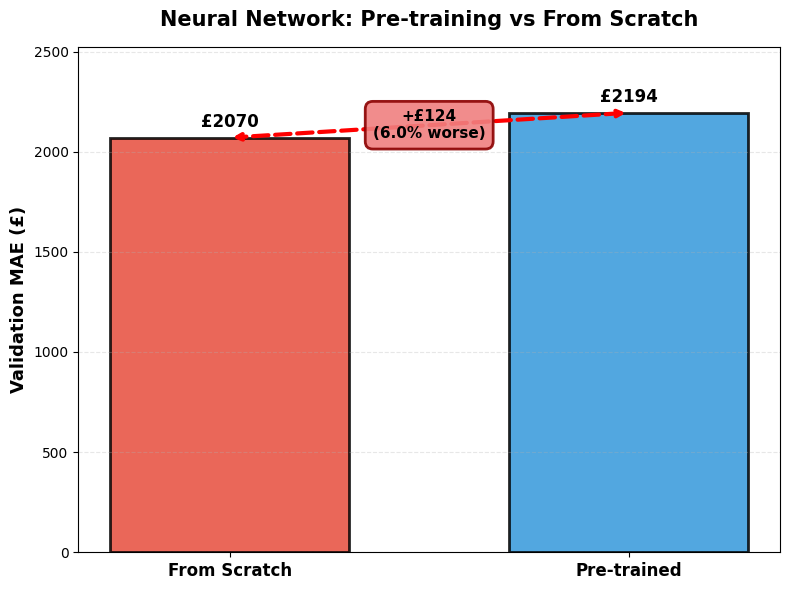

In [18]:
# VISUALIZATION: MODEL COMPARISON

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Data
models = results_df['Model']
maes = results_df['Validation MAE (£)']
colors = ['#e74c3c', '#3498db']

# Create bars
x_pos = [0, 1]
bars = ax.bar(x_pos, maes, color=colors, alpha=0.85, width=0.6, edgecolor='black', linewidth=2)

# Styling
ax.set_ylabel('Validation MAE (£)', fontsize=13, fontweight='bold')
ax.set_title('Neural Network: Pre-training vs From Scratch', fontsize=15, fontweight='bold', pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(models, fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, maes.max() * 1.15)

# Add MAE values on bars
for i, (bar, mae) in enumerate(zip(bars, maes)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + maes.max()*0.015,
            f'£{mae:.0f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add improvement info 
improvement = best_mae_scratch - best_mae_pretrained  
improvement_pct = ((best_mae_scratch - best_mae_pretrained) / best_mae_scratch) * 100 

# Highlight the improvement
mid_y = (maes[0] + maes[1]) / 2
if improvement > 0:
    # Arrow showing improvement
    ax.annotate('', xy=(1, maes[1]), xytext=(0, maes[0]),
                arrowprops=dict(arrowstyle='<->', color='green', lw=3, ls='--'))
    
    # Improvement text
    ax.text(0.5, mid_y, f'−£{improvement:.0f}\n({improvement_pct:.1f}% better)',
            ha='center', va='center', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', 
                     edgecolor='darkgreen', linewidth=2, alpha=0.9))
else:
    # If pre-training made it worse
    ax.annotate('', xy=(0, maes[0]), xytext=(1, maes[1]),
                arrowprops=dict(arrowstyle='<->', color='red', lw=3, ls='--'))
    
    ax.text(0.5, mid_y, f'+£{abs(improvement):.0f}\n({abs(improvement_pct):.1f}% worse)',
            ha='center', va='center', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', 
                     edgecolor='darkred', linewidth=2, alpha=0.9))

plt.tight_layout()
plt.show()

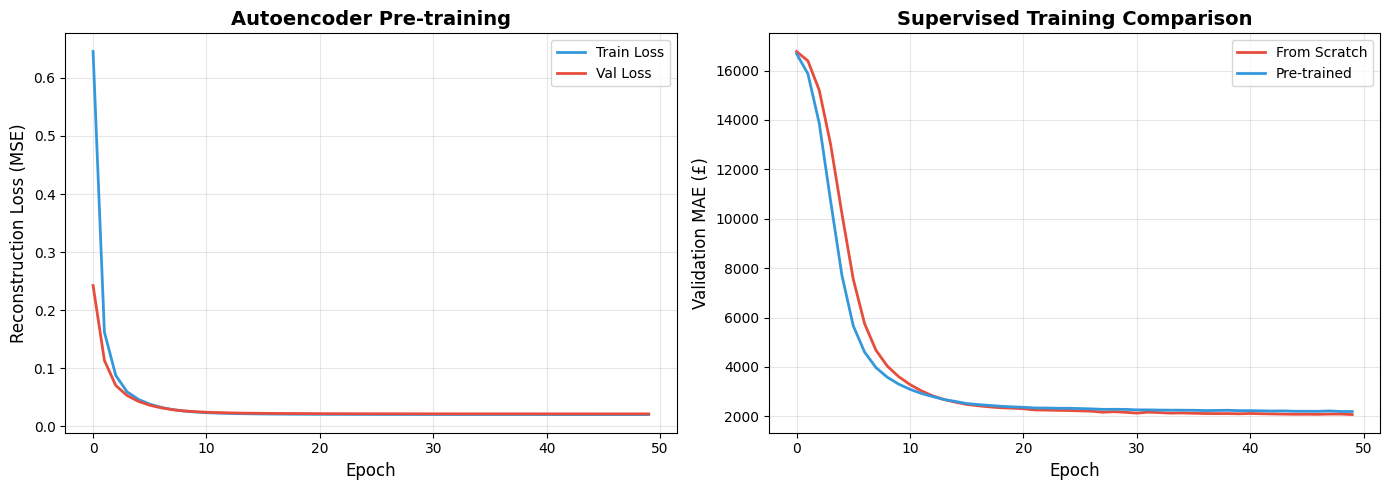

In [19]:
# VISUALIZATION: TRAINING HISTORY

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Pre-training
axes[0].plot(train_losses_pretrain, label='Train Loss', color='#3498db', linewidth=2)
axes[0].plot(val_losses_pretrain, label='Val Loss', color='#e74c3c', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Reconstruction Loss (MSE)', fontsize=12)
axes[0].set_title('Autoencoder Pre-training', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right plot: Fine-tuning
axes[1].plot(val_maes_scratch, label='From Scratch', color='#e74c3c', linewidth=2)
axes[1].plot(val_maes_pretrained, label='Pre-trained', color='#3498db', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation MAE (£)', fontsize=12)
axes[1].set_title('Supervised Training Comparison', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()